In [617]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px


#data = pd.read_csv(f"tweetsdata_16.csv")
data = pd.read_csv(f"test_dataset.csv")
#print(data)

In [618]:
#calculate tweets per hashtag
users = data['Username']
num_each_hashtag = {
    'climatechange':0,
    'climatecrisis': 0,
    'climatestrikeonline': 0,
    'agw': 0,
    'globalwarming': 0,
    'savetheplanet': 0,
    'climateemergency': 0  
}

num_users_per_hashtag = {
    'climatechange':0,
    'climatecrisis': 0,
    'climatestrikeonline': 0,
    'agw': 0,
    'globalwarming': 0,
    'savetheplanet': 0,
    'climateemergency': 0  
}

#lists for checking individual users per hashtag
users_in_climatechange = []
users_in_climatecrisis = []
users_in_climatestrikeonline = []
users_in_agw = []
users_in_globalwarming = []
users_in_savetheplanet = []
users_in_climateemergency = []

for index, tweet in enumerate(data['Hashtags']):
    if 'agw' in tweet:
        num_each_hashtag['agw'] += 1
        if not users[index] in users_in_agw:
            users_in_agw.append(users[index])
            num_users_per_hashtag['agw'] += 1
            
    if 'climatechange' in tweet:
        num_each_hashtag['climatechange'] += 1
        if not users[index] in users_in_climatechange:
            users_in_climatechange.append(users[index])
            num_users_per_hashtag['climatechange'] += 1
            
    if 'climatecrisis' in tweet:
        num_each_hashtag['climatecrisis'] += 1
        if not users[index] in users_in_climatecrisis:
            users_in_climatecrisis.append(users[index])
            num_users_per_hashtag['climatecrisis'] += 1
            
    if 'climatestrikeonline' in tweet:
        num_each_hashtag['climatestrikeonline'] += 1
        if not users[index] in users_in_climatestrikeonline:
            users_in_climatestrikeonline.append(users[index])
            num_users_per_hashtag['climatestrikeonline'] += 1
            
    if 'globalwarming' in tweet:
        num_each_hashtag['globalwarming'] += 1
        if not users[index] in users_in_globalwarming:
            users_in_globalwarming.append(users[index])
            num_users_per_hashtag['globalwarming'] += 1
        
    if 'savetheplanet' in tweet:
        num_each_hashtag['savetheplanet'] += 1
        if not users[index] in users_in_savetheplanet:
            users_in_savetheplanet.append(users[index])
            num_users_per_hashtag['savetheplanet'] += 1
        
    if 'climateemergency' in tweet:
        num_each_hashtag['climateemergency'] += 1
        if not users[index] in users_in_climateemergency:
            users_in_climateemergency.append(users[index])
            num_users_per_hashtag['climateemergency'] += 1

print(num_each_hashtag)

{'climatechange': 1330, 'climatecrisis': 1202, 'climatestrikeonline': 367, 'agw': 9, 'globalwarming': 1183, 'savetheplanet': 1045, 'climateemergency': 628}


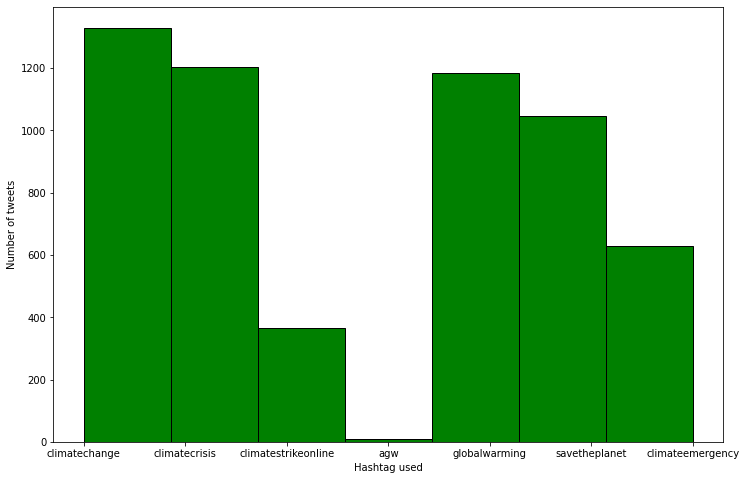

In [619]:
#show number of tweets per hashtag
plt.figure(figsize=(12,8))
list = [key for key, val in num_each_hashtag.items() for _ in range(val)]
plt.hist(list, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of tweets')
plt.xlabel('Hashtag used')
plt.show()

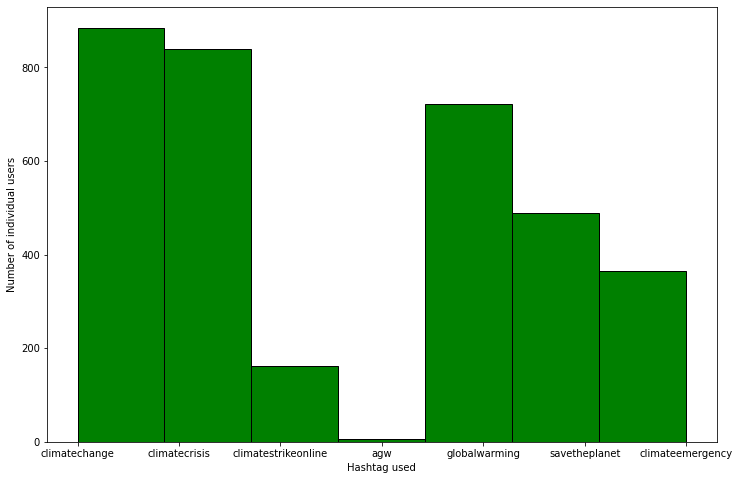

In [620]:
#show number of users per hashtag
plt.figure(figsize=(12,8))
list = [key for key, val in num_users_per_hashtag.items() for _ in range(val)]
plt.hist(list, bins=7, color='green',edgecolor='black')
plt.ylabel('Number of individual users')
plt.xlabel('Hashtag used')
plt.show()

{'en': 4549, 'th': 4, 'und': 573, 'fr': 49, 'pl': 1, 'es': 53, 'tl': 3, 'zh': 0, 'it': 17, 'et': 1, 'pt': 8, 'ja': 8, 'de': 38, 'ur': 0, 'sv': 3, 'cy': 0, 'fa': 0, 'hi': 42, 'ta': 6, 'ro': 10}


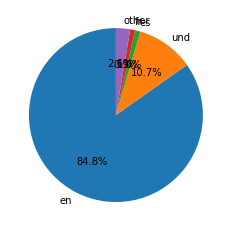

In [621]:
#language of tweets
num_each_lang = {
    'en':0,
    'th': 0,
    'und': 0,
    'fr': 0,
    'pl': 0,
    'es': 0,
    'tl': 0,
    'zh': 0,
    'it':0,
    'et': 0,
    'pt': 0,
    'ja': 0,
    'de': 0,
    'ur': 0,
    'sv': 0,
    'cy': 0,
    'fa': 0,
    'hi': 0,
    'ta': 0,
    'ro': 0
}

#labels and datalist for most popular languages
labels = ['en', 'und', 'es', 'fr', 'other']
languages = [0,0,0,0,0]

for lang in data['Language']:
    if lang == 'en':
        num_each_lang['en'] += 1
        languages[0] += 1
    if lang == 'th':
        num_each_lang['th'] += 1
        languages[4] += 1
    if lang == 'und':
        num_each_lang['und'] += 1
        languages[1] += 1
    if lang == 'fr':
        num_each_lang['fr'] += 1
        languages[3] += 1
    if lang == 'pl':
        num_each_lang['pl'] += 1
        languages[4] += 1
    if lang == 'es':
        num_each_lang['es'] += 1
        languages[2] += 1
    if lang == 'tl':
        num_each_lang['tl'] += 1
        languages[4] += 1
    if lang == 'zh':
        num_each_lang['zh'] += 1
        languages[4] += 1
    if lang == 'it':
        num_each_lang['it'] += 1
        languages[4] += 1
    if lang == 'et':
        num_each_lang['et'] += 1
        languages[4] += 1
    if lang == 'pt':
        num_each_lang['pt'] += 1
        languages[4] += 1
    if lang == 'ja':
        num_each_lang['ja'] += 1
        languages[4] += 1
    if lang == 'de':
        num_each_lang['de'] += 1
        languages[4] += 1
    if lang == 'ur':
        num_each_lang['ur'] += 1
        languages[4] += 1
    if lang == 'sv':
        num_each_lang['sv'] += 1
        languages[4] += 1
    if lang == 'cy':
        num_each_lang['cy'] += 1
        languages[4] += 1
    if lang == 'fa':
        num_each_lang['fa'] += 1
        languages[4] += 1
    if lang == 'hi':
        num_each_lang['hi'] += 1
        languages[4] += 1
    if lang == 'ta':
        num_each_lang['ta'] += 1
        languages[4] += 1
    if lang == 'ro':
        num_each_lang['ro'] += 1
        languages[4] += 1

print(num_each_lang)

fig1, ax1 = plt.subplots()
ax1.pie(languages, labels=labels, autopct='%1.1f%%', startangle=90)

plt.show()

In [622]:
#show geographic information of the tweets
from math import isnan

for index, g in enumerate(data['Geo']):
    try:
        g_is_nan = isnan(g)
    except TypeError:
        print(g)

{'place_id': '01e215db7136a37e'}
{'place_id': '06168d1feda43857'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': 'a0583a9994e6bf1b'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '219759301b4d8d23'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '7929cea6bd5b32bd'}
{'place_id': '18fe14b600b2c393'}
{'place_id': '4650a1e28c4d2dae'}
{'place_id': '74effb34539b2d64'}
{'place_id': '72606cdcf2847dd4'}
{'place_id': '5f55bb82cf16ac81'}
{'place_id': '5f55bb82cf16ac81'}
{'place_id': '0102ed48501a4846'}
{'place_id': '2cb13abdf90880ee'}
{'place_id': 'e7c97cdfef3a741a'}
{'place_id': 'f1d3a53f8a3cc7e9'}
{'place_id': '51ecc187876de86b'}
{'place_id': 'f1d3a53f8a3cc7e9'}
{'place_id': '07d9cdecf7886002'}
{'place_id': '009924a469d7ace1', 'coordinates': {'type': 'Point', 'coordinates': [-79.8996, -2.1761]}}
{'place_id': '009924a469d7ace1', 'coordinates': {'type': 'Point', 'coordinates': [-79.8996, -2.1761]}}
{'place_id': '3df4f427b5a60fea'}
{'place_id': '6a6d896ba1cb5dc4'}
{'

In [623]:
#vader tool analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
vader_data = []
for index, sentence in enumerate(data['Text']):
    vs = analyzer.polarity_scores(sentence)
    vader_data.append(vs)
    #print("{} {}".format(index, vs))
    
fig = px.scatter_ternary(vader_data, a="neg", b="neu", c="pos")
fig.show()

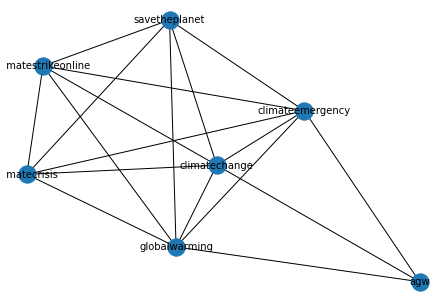

In [624]:
#construct a social graph
import networkx as nx

G = nx.Graph()

all_hashtags = ['climatechange',
    'climatecrisis',
    'climatestrikeonline',
    'agw',
    'globalwarming',
    'savetheplanet',
    'climateemergency']

adjacent_nodes = {
    'climatechange':[],
    'climatecrisis': [],
    'climatestrikeonline': [],
    'agw': [],
    'globalwarming': [],
    'savetheplanet': [],
    'climateemergency': []  
}

#function for checking if there is an edge between nodes
def check_adjacent(node, list_of_hashtags):
    if 'agw' in list_of_hashtags and 'agw' != node:
        if not 'agw' in adjacent_nodes[node]:
            adjacent_nodes[node] += ['agw']

    if 'climatechange' in list_of_hashtags and 'climatechange' != node:
        if not 'climatechange' in adjacent_nodes[node]:
            adjacent_nodes[node] += ['climatechange']

    if 'climatecrisis' in list_of_hashtags and 'climatecrisis' != node:
        if not 'climatecrisis' in adjacent_nodes[node]:
            adjacent_nodes[node] += ['climatecrisis']

    if 'climatestrikeonline' in list_of_hashtags and 'climatestrikeonline' != node:
        if not 'climatestrikeonline' in adjacent_nodes[node]:
            adjacent_nodes[node] += ['climatestrikeonline']

    if 'globalwarming' in list_of_hashtags and 'globalwarming' != node:
        if not 'globalwarming' in adjacent_nodes[node]:
            adjacent_nodes[node] += ['globalwarming']

    if 'savetheplanet' in list_of_hashtags and 'savetheplanet' != node:
        if not 'savetheplanet' in adjacent_nodes[node]:
            adjacent_nodes[node] += ['savetheplanet']

    if 'climateemergency' in list_of_hashtags and 'climateemergency' != node:
        if not 'climateemergency' in adjacent_nodes[node]:
            adjacent_nodes[node] += ['climateemergency']

#go through all the tweets and check if there should be edge between certain hashtags
for tweet in data['Hashtags']:
    if 'agw' in tweet:
        check_adjacent('agw', tweet)
    if 'climatechange' in tweet:
        check_adjacent('climatechange', tweet)
    if 'climatecrisis' in tweet:
        check_adjacent('climatecrisis', tweet)
    if 'climatestrikeonline' in tweet:
        check_adjacent('climatestrikeonline', tweet)
    if 'globalwarming' in tweet:
        check_adjacent('globalwarming', tweet)
    if 'savetheplanet' in tweet:
        check_adjacent('savetheplanet', tweet)
    if 'climateemergency' in tweet:
        check_adjacent('climateemergency', tweet)
    
#print(adjacent_nodes)

#add all the hashtags as nodes to the graph
for tag in all_hashtags:
    G.add_node(tag)
    
#add all the necessary edges with the help of adjacent_nodes dictionary
for node in adjacent_nodes:
    for i in range(len(adjacent_nodes[node])):
        #print(node, adjacent_nodes[node][i])
        G.add_edge(node, adjacent_nodes[node][i])


nx.draw(G, with_labels=True, font_size=10)

In [625]:
#calculate main global properties of the graph
# number of nodes in variable
num_nodes = G.number_of_nodes()
# number of edges in variable 
num_edges = G.number_of_edges()
# degree centrality in a variable
degree_centrality = nx.degree_centrality(G)

degree_sum = 0
# average degree centrality
average_degree_centrality = sum(degree_centrality.values())/num_nodes

dia = nx.diameter(G)

clustering_coefficient = nx.average_clustering(G)

# size of the largest component
components = [x for x in nx.connected_components(G)]
largest_component = max(components, key=len)

data = {'Number of nodes': num_nodes,
        'Number of edges': num_edges,
        'Average degree centrality': average_degree_centrality,
        'Diameter': dia,
        'Clustering coefficient': clustering_coefficient,
        'Size of largest component': len(largest_component)}

main_properties_dataframe = pd.DataFrame(data, index=['-'])
print(main_properties_dataframe)

   Number of nodes  Number of edges  Average degree centrality  Diameter  \
-                7               18                   0.857143         2   

   Clustering coefficient  Size of largest component  
-                0.914286                          7  


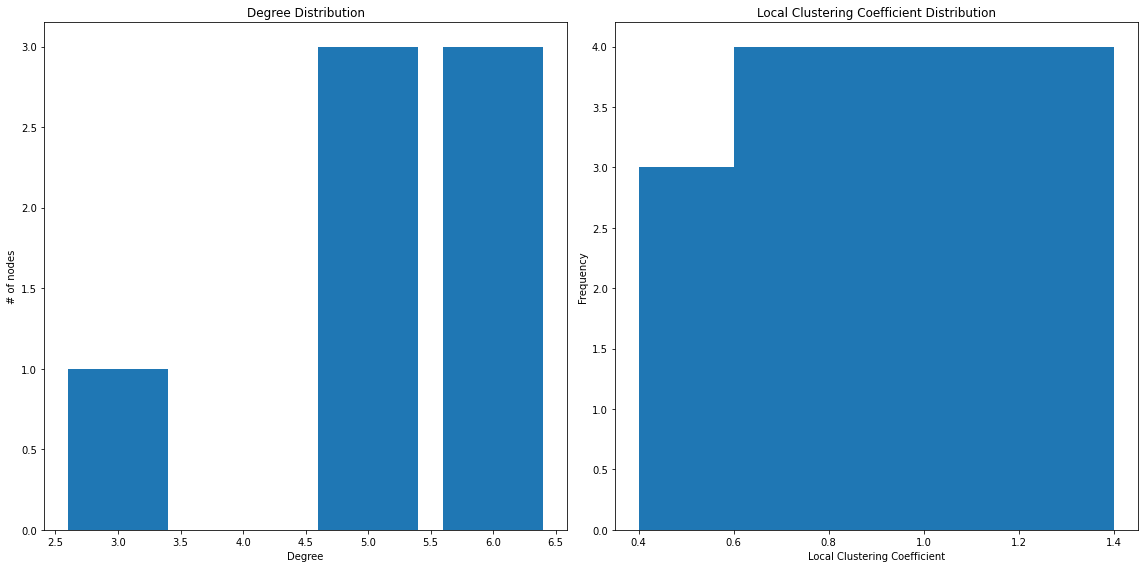

In [626]:
# Plot the degree distribution and local clustering coeffisient distribution
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
local_clustering_sequence = sorted(nx.clustering(G).values(), reverse=True)
dmax = max(degree_sequence)
cmax = max(local_clustering_sequence)

fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121)
ax1.bar(*np.unique(degree_sequence, return_counts=True))
ax1.set_title("Degree Distribution")
ax1.set_xlabel("Degree")
ax1.set_ylabel("# of nodes")

ax2 = fig.add_subplot(122)
ax2.bar(*np.unique(local_clustering_sequence, return_counts=True))
ax2.set_title("Local Clustering Coefficient Distribution")
ax2.set_xlabel("Local Clustering Coefficient")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()
